레퍼런스
* https://github.com/shreyasharma98/Cohort-Analysis/blob/master/Cohort%20Analysis.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('online_retail_II.xlsx')

In [3]:
#월별로 date 데이터 변환
df['InvoiceDate_month'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y%m'))

In [4]:
#일별로 date 데이터 변환
df['InvoiceDate_date'] = df['InvoiceDate'].map(lambda date: date.strftime('%Y%m%d'))

In [5]:
#매출 컬럼 생성
df['sales'] = df['Quantity'] * df['Price']

## Monthly retention rate
* 지난달에 구매하고 재구매한 경우를 고객이 유지되었다고 보고 retention rate 계산

In [6]:
# MAU: 월별 1회 이상 구매한 고객의 수
mau = pd.DataFrame(df.groupby('InvoiceDate_month').nunique()['Customer ID'].reset_index()).rename(columns={'Customer ID':'mau'})

In [7]:
monthly_sales_per_user = df.groupby(['Customer ID', 'InvoiceDate_month'])['sales'].sum().reset_index()

In [8]:
mspu_pv = pd.pivot_table(monthly_sales_per_user, index=['Customer ID'], columns='InvoiceDate_month', aggfunc=np.sum).fillna(0).reset_index()

In [9]:
mspu_pv.columns = mspu_pv.columns.droplevel(0) #멀티 컬럼 제거

In [10]:
mspu_pv = mspu_pv.rename(columns={'':'customer_id'})

In [11]:
months = list(mspu_pv.columns[1:])

retained_users = list()
retained_users.append(0)

for i in range(1, len(months)):
    prev_month = months[i-1]
    month = months[i]
    ru = mspu_pv[(mspu_pv[prev_month]>0) & (mspu_pv[month]>0)][month].count()
    retained_users.append(ru)

In [12]:
mau['retained_users'] = retained_users

In [13]:
mau['retention_rate'] = mau['retained_users'] / mau['mau'] * 100

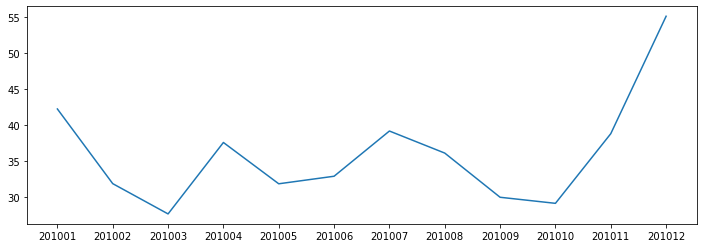

In [14]:
plt.figure(figsize=(12,4))
plt.plot(mau['InvoiceDate_month'][1:], mau['retention_rate'][1:])
plt.show()

* 2010년 11월 이후 리텐션은 증가 추세에 있음.
* 11월에 사용자가 늘어났는데 이후 재구매율이 높아진 것으로 보임.
* 어떤 유저들이 재구매하고 있는지는 코호트 분석으로 확인해 봐야 함.

# Cohort Analysis : Retention Rate
*  처음 물품을 구매한 달을 기준으로 코호트 분석을 진행함.

In [15]:
monthly_sales_per_user = monthly_sales_per_user[monthly_sales_per_user.sales>0]
first_mt = pd.DataFrame(monthly_sales_per_user.groupby('Customer ID')['InvoiceDate_month'].min()).reset_index() #고객별 주문이 가장 이른 달을 구해 코호트 그룹을 지정해준다

In [16]:
first_mt = first_mt.rename(columns={'InvoiceDate_month':'first_month'})

In [17]:
monthly_sales_per_user = pd.merge(monthly_sales_per_user, first_mt, on='Customer ID', how='left')

In [18]:
monthly_sales_per_user['purchase_or_not'] = monthly_sales_per_user.sales > 0

In [19]:
monthly_sales_per_user['purchase_or_not'] = monthly_sales_per_user['purchase_or_not'].astype(int)

In [21]:
cohort_stat = monthly_sales_per_user.groupby(['first_month', 'InvoiceDate_month']).agg({'Customer ID': pd.Series.nunique}) #코호트 그룹 - 구매월별로 구매 회원 수를 게산

In [28]:
cohort_stat = cohort_stat.rename(columns={'first_month': 'cohort', 'Customer ID':'customers'}).reset_index()

In [32]:
def cohort_period(df):

    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohort_stat = cohort_stat.groupby(by='cohort').apply(cohort_period)

In [34]:
cohort_stat.set_index(['cohort', 'CohortPeriod'], inplace=True)

In [36]:
#코호트 그룹별 최초 유저수 데이터프레임 생성
cohort_group_size = cohort_stat['customers'].groupby(level=0).first()
cohort_group_size.head(5)

cohort
200912    945.0
201001    385.0
201002    373.0
201003    441.0
201004    291.0
Name: customers, dtype: float64

In [41]:
retention = cohort_stat['customers'].unstack(0).divide(cohort_group_size, axis=1)

<AxesSubplot:title={'center':'월별 코호트 구매 리텐션'}, xlabel='CohortPeriod', ylabel='cohort'>

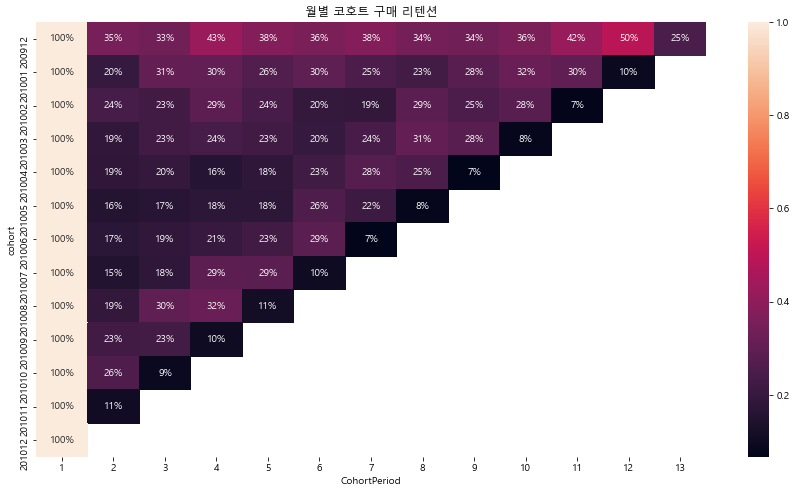

In [46]:
import seaborn as sns

plt.figure(figsize=(15,8))
plt.title('월별 코호트 구매 리텐션')
plt.rc('font', family='Malgun Gothic') #한글 폰트 설정
sns.heatmap(retention.T, mask=retention.T.isnull(), annot=True, fmt='.0%')

* 최근 처음으로 구매한 신규 유저가 아니라 2009년 12월에 처음 구매 경험을 한 유저들의 재구매율이 점차 개선되고 있음.
* 반면 이후에 처음 구매 경험을 유저들은 리텐션이 전 기간에 걸쳐 30% 이하인 경우가 다수여서 개선이 시급함.
* 단 2010년 중순 구매 후 첫달 리텐션이 15%대로 떨어졌다가 이후 차츰 상승세여서 차츰 호전되고 있는 것으로 판단됨.
* 또한 2010년 중순 코호트의 경우에도 시간이 지나면서 리텐션이 개선되고 있는 추세임.
* 가장 구매율이 높은 2009년 12월 코호트 유저들이 어떻게 사이트에 랜딩해서 구매경험을 가져가고 있는지, 어떤 성향의 유저들인지 추가 분석이 필요해 보임.